In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =5e-25

nband = 80

ng =5

ng_adju = (/ 1 /) 

ng_refs = (/ 2 , 3 /) 

nref =2

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 100 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 720

data w_diffuse
     &     /1.55 , 1.6 , 1.66 , 1.66,
     &     1.8/

data wgt
     &     /0.5 , 0.5 , 0.6 , 0.7,
     &     0.9/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

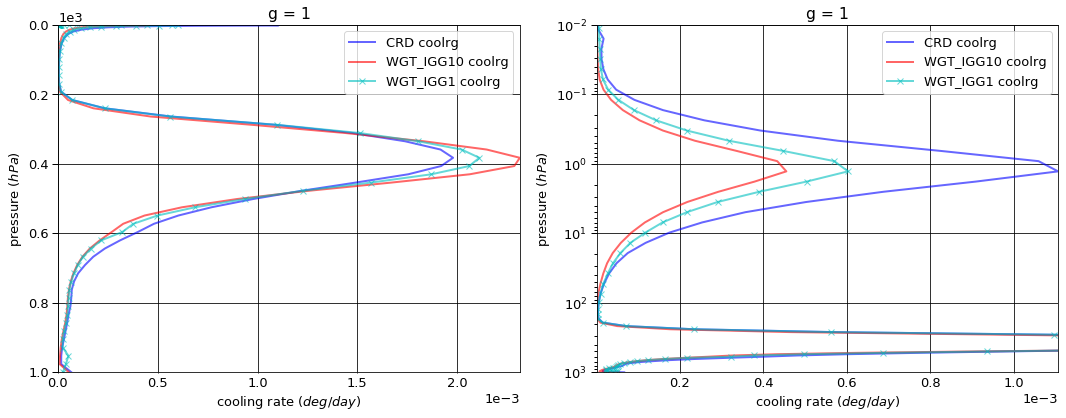

# Figure: cooling rate g-group 2

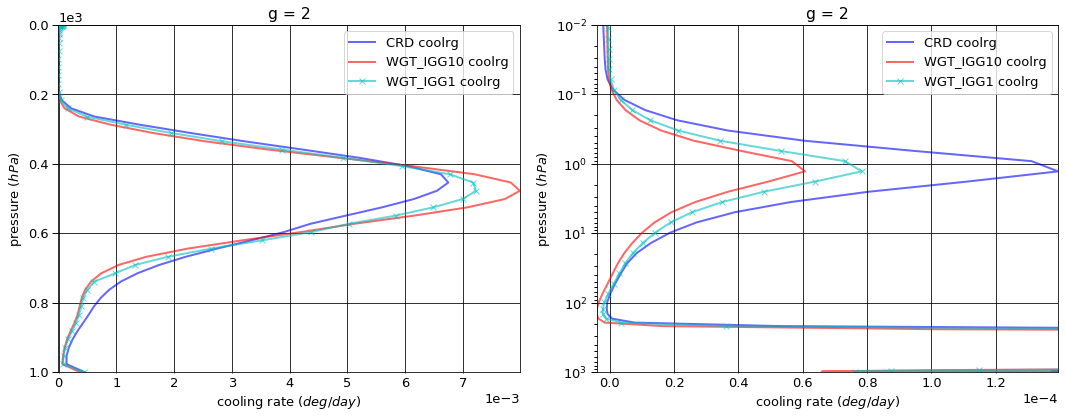

# Figure: cooling rate g-group 3

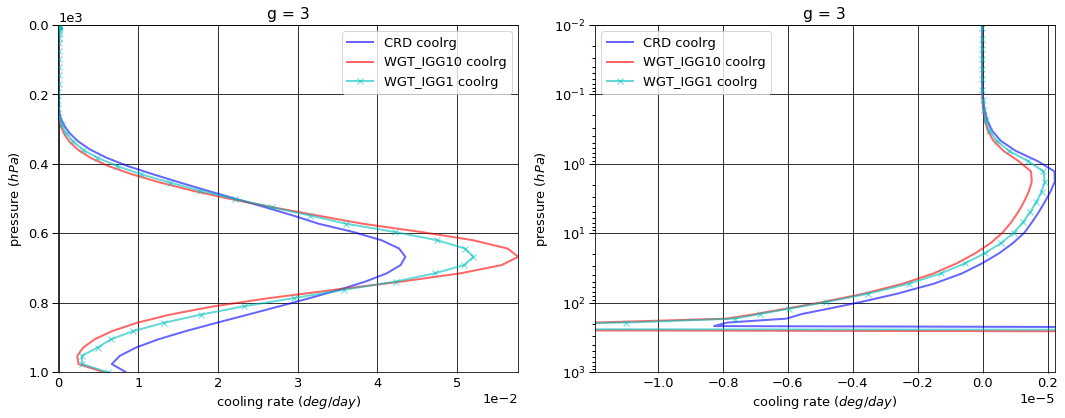

# Figure: cooling rate g-group 4

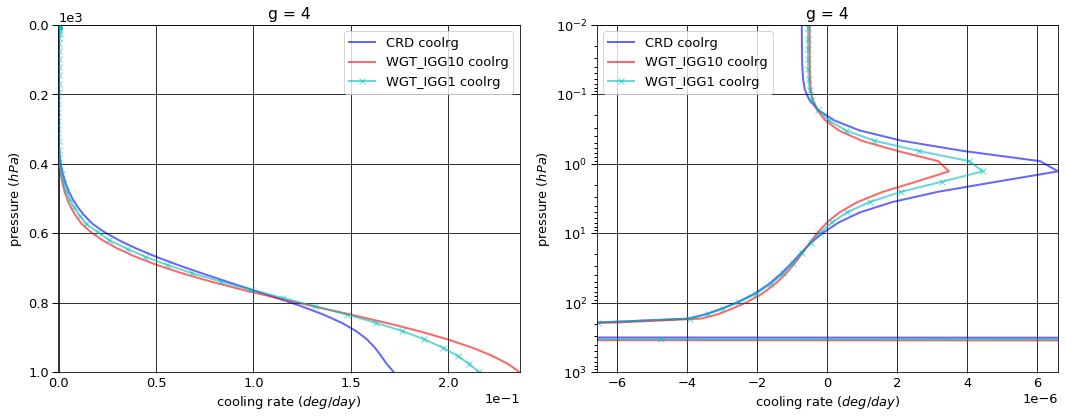

# Figure: cooling rate g-group 5

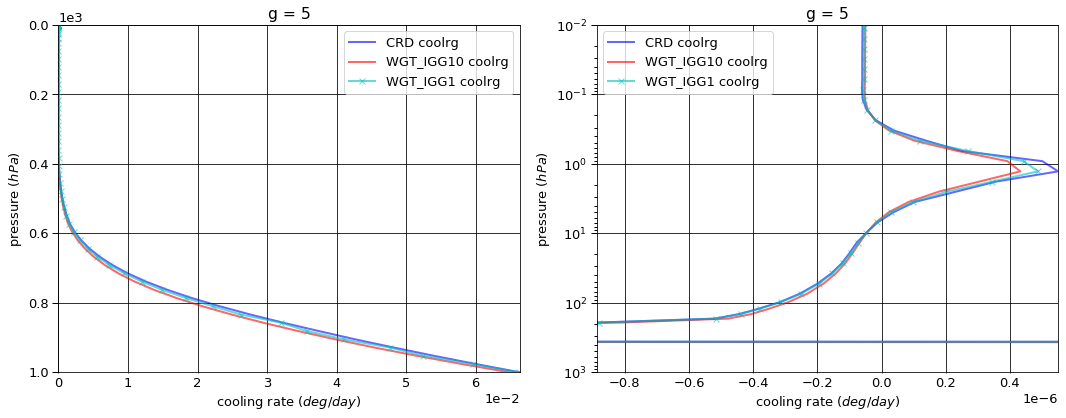

# Figure: cooling rate g-group total

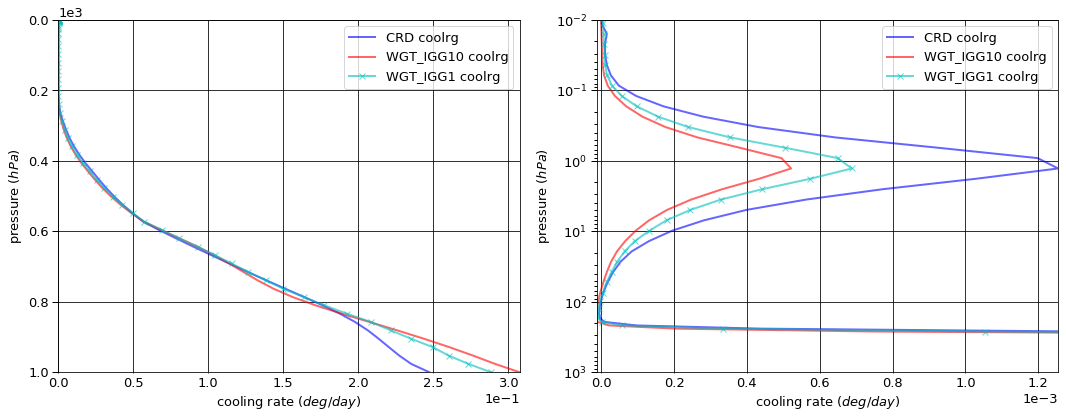

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.058067  0.000000  -0.058067
  1013.0   76     -0.119737  0.119564  -0.000173
2 0.0      1      -0.241871  0.000000  -0.241871
  1013.0   76     -0.427007  0.425597  -0.001410
3 0.0      1      -1.912781  0.000000  -1.912781
  1013.0   76     -2.616338  2.577328  -0.039010
4 0.0      1     -11.850170  0.000000 -11.850170
  1013.0   76    -12.664747  6.510957  -6.153789
5 0.0      1     -16.677215  0.000000 -16.677215
  1013.0   76    -16.809714  1.479187 -15.330527


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.057825  0.000000  -0.057825
  1013.0   76     -0.119737  0.119593  -0.000144
2 0.0      1      -0.242031  0.000000  -0.242031
  1013.0   76     -0.427007  0.426018  -0.000989
3 0.0      1      -1.885893  0.000000  -1.885893
  1013.0   76     -2.616338  2.597981  -0.018357
4 0.0      1     -11.899872  0.000000 -11.899872
  1013.0   76    -12.664747  7.186837  -5.477909
5 0.0      1     -16.691120  0.000000 -16.691120
  1013.0   76    -16.809714  1.369074 -15.440640


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.057523  0.000000  -0.057523
  1013.0   76     -0.119737  0.119667  -0.000069
2 0.0      1      -0.241701  0.000000  -0.241701
  1013.0   76     -0.427007  0.425833  -0.001174
3 0.0      1      -1.889080  0.000000  -1.889080
  1013.0   76     -2.616338  2.595251  -0.021087
4 0.0      1     -11.861769  0.000000 -11.861769
  1013.0   76    -12.664747  7.080932  -5.583815
5 0.0      1     -16.682414  0.000000 -16.682414
  1013.0   76    -16.809714  1.436906 -15.372808


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      2.413760e-04  0.000000  0.000241
  1013.0   76     0.000000e+00  0.000029  0.000029
2 0.0      1     -1.605000e-04  0.000000 -0.000161
  1013.0   76    -5.551115e-17  0.000421  0.000421
3 0.0      1      2.688830e-02  0.000000  0.026888
  1013.0   76     0.000000e+00  0.020653  0.020653
4 0.0      1     -4.970200e-02  0.000000 -0.049702
  1013.0   76     0.000000e+00  0.675880  0.675880
5 0.0      1     -1.390500e-02  0.000000 -0.013905
  1013.0   76     0.000000e+00 -0.110114 -0.110113


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      5.439680e-04  0.000000  0.000544
  1013.0   76     0.000000e+00  0.000104  0.000104
2 0.0      1      1.701700e-04  0.000000  0.000170
  1013.0   76    -5.551115e-17  0.000236  0.000236
3 0.0      1      2.370050e-02  0.000000  0.023700
  1013.0   76     0.000000e+00  0.017923  0.017923
4 0.0      1     -1.159900e-02  0.000000 -0.011599
  1013.0   76     0.000000e+00  0.569975  0.569975
5 0.0      1     -5.199000e-03  0.000000 -0.005199
  1013.0   76     0.000000e+00 -0.042281 -0.042281

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.948596e-06
  1001.112500 75     6.743264e-05
2 0.000312    1     -2.843426e-06
  1001.112500 75     4.548422e-04
3 0.000312    1     -1.527137e-08
  1001.112500 75     8.480017e-03
4 0.000312    1     -7.312484e-07
  1001.112500 75     1.720271e-01
5 0.000312    1     -5.658241e-08
  1001.112500 75     6.635914e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -4.153231e-06
  1001.112500 75     5.478878e-05
2 0.000312    1     -1.214080e-06
  1001.112500 75     3.751633e-04
3 0.000312    1     -1.975041e-08
  1001.112500 75     5.756822e-03
4 0.000312    1     -4.942555e-07
  1001.112500 75     2.366024e-01
5 0.000312    1     -4.779244e-08
  1001.112500 75     6.487270e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.012176e-06
  1001.112500 75     2.497724e-05
2 0.000312    1     -1.091081e-06
  1001.112500 75     4.373704e-04
3 0.000312    1     -2.043787e-08
  1001.112500 75     6.149630e-03
4 0.000312    1     -5.489887e-07
  1001.112500 75     2.157833e-01
5 0.000312    1     -5.182718e-08
  1001.112500 75     6.619681e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.046348e-07
  1001.112500 75    -1.264386e-05
2 0.000312    1      1.629346e-06
  1001.112500 75    -7.967891e-05
3 0.000312    1     -4.479040e-09
  1001.112500 75    -2.723196e-03
4 0.000312    1      2.369929e-07
  1001.112500 75     6.457532e-02
5 0.000312    1      8.789967e-09
  1001.112500 75    -1.486439e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.936420e-06
  1001.112500 75    -4.245540e-05
2 0.000312    1      1.752345e-06
  1001.112500 75    -1.747180e-05
3 0.000312    1     -5.166507e-09
  1001.112500 75    -2.330387e-03
4 0.000312    1      1.822597e-07
  1001.112500 75     4.375617e-02
5 0.000312    1      4.755228e-09
  1001.112500 75    -1.623270e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.740103,0.000000,-30.740103
1013.0,76,-32.637543,11.112634,-21.524909



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.776741,0.000000,-30.776741
1013.0,76,-32.637543,11.699503,-20.938040



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.732487,0.00000,-30.732487
1013.0,76,-32.637543,11.65859,-20.978953



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.036638,0.000000,-0.036638
1013.0,76,0.000000,0.586869,0.586869



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.007617,0.000000,0.007617
1013.0,76,0.000000,0.545956,0.545956


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000008
1001.112500,75,0.247389



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.307662



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.288592



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000002
1001.112500,75,0.060273



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000005
1001.112500,75,0.041204


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.003675,0.003665
2,0.013137,0.013045
3,0.080437,0.079972
4,0.388950,0.387357
5,0.513800,0.515961


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,6.158640e-22
2,6.642950e-23
3,1.195213e-23
4,5.001064e-25
5,3.765264e-26


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,6.158640e-22,NaN,0.003675,0.003665,0.003675,0.003665,100.0
2,6.642950e-23,0.107864,0.013137,0.013045,0.016813,0.016710,100.0
3,1.195213e-23,0.179922,0.080437,0.079972,0.097250,0.096682,600.0
4,5.001064e-25,0.041842,0.388950,0.387357,0.486200,0.484039,600.0
5,3.765264e-26,0.075289,0.513800,0.515961,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
